# CS614 Assignment 1 - LLM Training Code

In [ ]:
!pip install transformers evaluate datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 19.5 MB/s eta 0:00:00


In [22]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, set_seed
import evaluate, torch, numpy as np, time, pandas as pd, numpy as np, matplotlib.pyplot as plt
from datasets import load_dataset, get_dataset_split_names
from collections import Counter
from peft import LoraConfig, PeftModel, get_peft_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Dataset**:
The dataset is obtained from https://huggingface.co/datasets/zeroshot/twitter-financial-news-sentiment. The dataset consists of 11,931 finance-related tweets and is used to train and evaluate the performance of sequence classification models on sentiment classification.

## **Task:**
Summarise news articles using the selected LLM.

In [3]:
#Load dataset
dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")

In [3]:
#Get split names
get_dataset_split_names("zeroshot/twitter-financial-news-sentiment")

['train', 'validation']

In [4]:
#load train, validation and test dataset
train = dataset["train"].shuffle(seed=42)
val = dataset["validation"].shuffle(seed=42)

train_size, val_size = int(0.8*len(train)), len(train)-int(0.8*len(train))
train_dataset = train.select(range(train_size))
val_dataset = train.select(range(train_size,))
test_dataset = val

In [5]:
#check the attributes (features) of dataset
train.features

{'text': Value('string'), 'label': Value('int64')}

`text`: Financial-related tweet
<br>`label`: Reference sentiment (0: Bearish, 1: Bullish, 2: Neutral)

In [6]:
#check distribution of classes in dataset
label_counts = Counter(train["label"])
print(label_counts)
train_label_counts = Counter(train_dataset["label"])
print(train_label_counts)

Counter({2: 6178, 1: 1923, 0: 1442})
Counter({2: 4929, 1: 1546, 0: 1159})


In [7]:
#check random subset of data
train[19]

{'text': 'Extreme Networks +3% after $100M buyback', 'label': 1}

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## **Import Model:**

BERT (Sequence Classification model of 110 million parameters) is used to perform this sentiment classification task. bert-cased variant is used as Capitalisation of letters can convey different meanings in tweets such as company names, emotions.

In [9]:
model_name = "google-bert/bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [10]:
#create functions to tokenize and compute evaluation metric
def tokenize_text(tweets):
  return tokenizer(tweets["text"], return_tensors="pt", padding="max_length").to("cuda")

accuracy = evaluate.load("accuracy")
f1_macro = evaluate.load("f1")

def compute_metrics(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  # return accuracy.compute(predictions=predictions, references=labels)
  return {"Accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"], "F1_macro":f1_macro.compute(predictions=predictions, references=labels, average="macro")["f1"]}

def model_instance():
  set_seed(42) #to initialise model at same checkpoint
  return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3).to(device)

In [11]:
train_dataset = train_dataset.map(tokenize_text, batched=True)
val_dataset = val_dataset.map(tokenize_text, batched=True)
test_dataset = test_dataset.map(tokenize_text, batched=True)

In [12]:
def train_LLM(trainer_class):
    start_time = time.time()
    trainer_class.train()
    end_time = time.time()
    time_taken = end_time - start_time
    print(time_taken)

## Evaluation: Accuracy and F1-Score (macro)
Accuracy - determines how well the model performs overall in classifying the tweet sentiment correctly
macro-F1 - measures how well the model can classify each sentiment class accurately, by averaging F1 over number of classes. This is robust against datasets with class imbalances (which is useful as tweets dataset have the majority class of neutral tweets and hence, the model has a higher probability of getting higher accuracy in predicting neutral when it is unsure). If minority F1 score low, it will show in the macro F1 score.

## Tune hyperparameters (Full fine tune)

In [13]:
results = {} # test metrics
run_count = 0
train_batch = [4, 8, 16]
gradient_accum = [1,2]
for train_bs in train_batch:
    for grad_acc in gradient_accum:
        print("=============================================================================================================================")
        print(f"Training batch size: {train_bs}, Gradient Accumulation Steps: {grad_acc}, Effective training batch size: {train_bs*grad_acc}")

        tuned_training_args = TrainingArguments(
            report_to="none",
            num_train_epochs=3,
            learning_rate=5e-5,
            per_device_train_batch_size=train_bs,
            per_device_eval_batch_size=16,
            weight_decay=0,
            warmup_ratio=0,
            gradient_accumulation_steps=grad_acc,
            adam_beta1=0.9,
            adam_beta2=0.999,
            adam_epsilon=1e-8,
            logging_dir='./logs',
            logging_steps=10,
            logging_strategy="epoch",
            output_dir="test_trainer",
            eval_strategy="epoch")

        tuned_trainer = Trainer(
            model=model_instance(),
            args=tuned_training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
            data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
        )

        train_LLM(tuned_trainer)
        print("Evaluating on test dataset")
        pred_output = tuned_trainer.predict(test_dataset)
        pred_logits = pred_output.predictions
        true_labels = pred_output.label_ids
        test_metrics = pred_output.metrics #get metrics
        print(test_metrics)
        run_count += 1
        results[run_count] = {'training batch size': train_bs, 'gradient accumulation steps': grad_acc, 'effective training batch size': round(train_bs*grad_acc),'loss':test_metrics['test_loss'], 'accuracy': test_metrics['test_Accuracy'], 'F1_macro': test_metrics['test_F1_macro']}
        print("=============================================================================================================================")

Training batch size: 4, Gradient Accumulation Steps: 1, Effective training batch size: 4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.756500,0.515725,0.851585,0.782556
2,0.519900,0.236035,0.942363,0.919251
3,0.289700,0.138446,0.970396,0.957643


1669.0338699817657
Evaluating on test dataset


{'test_loss': 0.6478491425514221, 'test_Accuracy': 0.8714405360134003, 'test_F1_macro': 0.8262291258258215, 'test_runtime': 41.3349, 'test_samples_per_second': 57.772, 'test_steps_per_second': 3.629}
Training batch size: 4, Gradient Accumulation Steps: 2, Effective training batch size: 8


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.645700,0.333642,0.883809,0.834674
2,0.378600,0.168167,0.954414,0.937722
3,0.193800,0.093889,0.976683,0.968177


1544.4175307750702
Evaluating on test dataset


{'test_loss': 0.6103212833404541, 'test_Accuracy': 0.8685092127303182, 'test_F1_macro': 0.8256099122326374, 'test_runtime': 35.7249, 'test_samples_per_second': 66.844, 'test_steps_per_second': 4.199}
Training batch size: 8, Gradient Accumulation Steps: 1, Effective training batch size: 8


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.635900,0.322731,0.898873,0.857000
2,0.343200,0.128878,0.965942,0.952474
3,0.166500,0.073522,0.984412,0.977776


1536.8633544445038
Evaluating on test dataset


{'test_loss': 0.6279516816139221, 'test_Accuracy': 0.8706030150753769, 'test_F1_macro': 0.8263500817561421, 'test_runtime': 36.1531, 'test_samples_per_second': 66.052, 'test_steps_per_second': 4.149}
Training batch size: 8, Gradient Accumulation Steps: 2, Effective training batch size: 16


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.611600,0.287119,0.901362,0.857671
2,0.294600,0.099743,0.971051,0.960347
3,0.129400,0.056599,0.986115,0.980740


1479.113431930542
Evaluating on test dataset


{'test_loss': 0.5348259210586548, 'test_Accuracy': 0.873534338358459, 'test_F1_macro': 0.833039315522186, 'test_runtime': 36.1939, 'test_samples_per_second': 65.978, 'test_steps_per_second': 4.144}
Training batch size: 16, Gradient Accumulation Steps: 1, Effective training batch size: 16


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.596400,0.278703,0.900838,0.863117
2,0.293600,0.116955,0.964632,0.951933
3,0.136100,0.058955,0.985067,0.978972


1461.4932072162628
Evaluating on test dataset


{'test_loss': 0.5429815053939819, 'test_Accuracy': 0.8722780569514238, 'test_F1_macro': 0.8330313193670001, 'test_runtime': 36.3215, 'test_samples_per_second': 65.746, 'test_steps_per_second': 4.13}
Training batch size: 16, Gradient Accumulation Steps: 2, Effective training batch size: 32


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.589100,0.270731,0.905685,0.868738
2,0.275900,0.091777,0.973277,0.962795
3,0.117000,0.047326,0.987687,0.982323


10284.50573849678
Evaluating on test dataset


{'test_loss': 0.4909021258354187, 'test_Accuracy': 0.8672529313232831, 'test_F1_macro': 0.8228919573439218, 'test_runtime': 481.8224, 'test_samples_per_second': 4.956, 'test_steps_per_second': 0.311}


## Comparison of metrics by visualisation

In [ ]:
#results_dict for plot when kernel restarts
histories = { #training metrics
    1: {"epochs":[1, 2, 3],
        "train_loss":[0.7565,0.5199,0.2897],
        "val_loss":[0.515725,0.236035,0.138446],
        "accuracy":[0.851585,0.942363,0.970396],
        "f1_macro":[0.782556,0.919251,0.957643],
        # (optional) keep config here too, if you want it in legends later
        "config": {"train_batch": 4, "grad_acc": 1, "effective_batch": 4},
    },
    2: {"epochs":[1, 2, 3],
        "train_loss":[0.6457,0.3786,0.1938],
        "val_loss":[0.333642,0.168167,0.093889],
        "accuracy":[0.883809,0.954414,0.976683],
        "f1_macro":[0.834674,0.937722,0.968177],
        "config":{"train_batch": 4, "grad_acc": 2, "effective_batch": 8},
    },
    3: {"epochs":[1, 2, 3],
        "train_loss":[0.6359,0.3432,0.1665],
        "val_loss":[0.322731,0.128878,0.073522],
        "accuracy":[0.898873,0.965942,0.984412],
        "f1_macro":[0.857,0.952474,0.977776],
        "config":{"train_batch": 8, "grad_acc": 1, "effective_batch": 8},
    },
    4: {"epochs":[1, 2, 3],
        "train_loss":[0.6116,0.2946,0.1294],
        "val_loss":[0.287119,0.099743,0.056599],
        "accuracy":[0.901362,0.971051,0.986115],
        "f1_macro":[0.857671,0.960347,0.98074],
        "config":{"train_batch": 8, "grad_acc": 2, "effective_batch": 16},
    },
    5: {"epochs":[1, 2, 3],
        "train_loss":[0.5964,0.2936,0.1361],
        "val_loss":[0.278703,0.116955,0.058955],
        "accuracy":[0.900838,0.964632,0.985067],
        "f1_macro":[0.863117,0.951933,0.978972],
        "config":{"train_batch": 16, "grad_acc": 1, "effective_batch": 16},
    },
    6: {"epochs":[1, 2, 3],
        "train_loss":[0.5891,0.2759,0.117],
        "val_loss":[0.270731,0.091777,0.047326],
        "accuracy":[0.905685,0.973277,0.987687],
        "f1_macro":[0.868738,0.962795,0.982323],
        "config":{"train_batch": 16, "grad_acc": 2, "effective_batch": 32},
    },
}
train_times = {1:1669.0338699817657,2:1544.4175307750702,3:1536.8633544445038,4:1479.113431930542,5:1461.4932072162628,6:10284.50573849678}
#test_metrics
results = {1: {'training batch size': 4, 'gradient accumulation steps': 1, 'effective training batch size': 4, 'loss': 0.6478491425514221, 'accuracy': 0.8714405360134003, 'F1_macro': 0.8262291258258215}, 2: {'training batch size': 4, 'gradient accumulation steps': 2, 'effective training batch size': 8, 'loss': 0.6103212833404541, 'accuracy': 0.8685092127303182, 'F1_macro': 0.8256099122326374}, 3: {'training batch size': 8, 'gradient accumulation steps': 1, 'effective training batch size': 8, 'loss': 0.6279516816139221, 'accuracy': 0.8706030150753769, 'F1_macro': 0.8263500817561421}, 4: {'training batch size': 8, 'gradient accumulation steps': 2, 'effective training batch size': 16, 'loss': 0.5348259210586548, 'accuracy': 0.873534338358459, 'F1_macro': 0.833039315522186}, 5: {'training batch size': 16, 'gradient accumulation steps': 1, 'effective training batch size': 16, 'loss': 0.5429815053939819, 'accuracy': 0.8722780569514238, 'F1_macro': 0.8330313193670001}, 6: {'training batch size': 16, 'gradient accumulation steps': 2, 'effective training batch size': 32, 'loss': 0.4909021258354187, 'accuracy': 0.8672529313232831, 'F1_macro': 0.8228919573439218}}


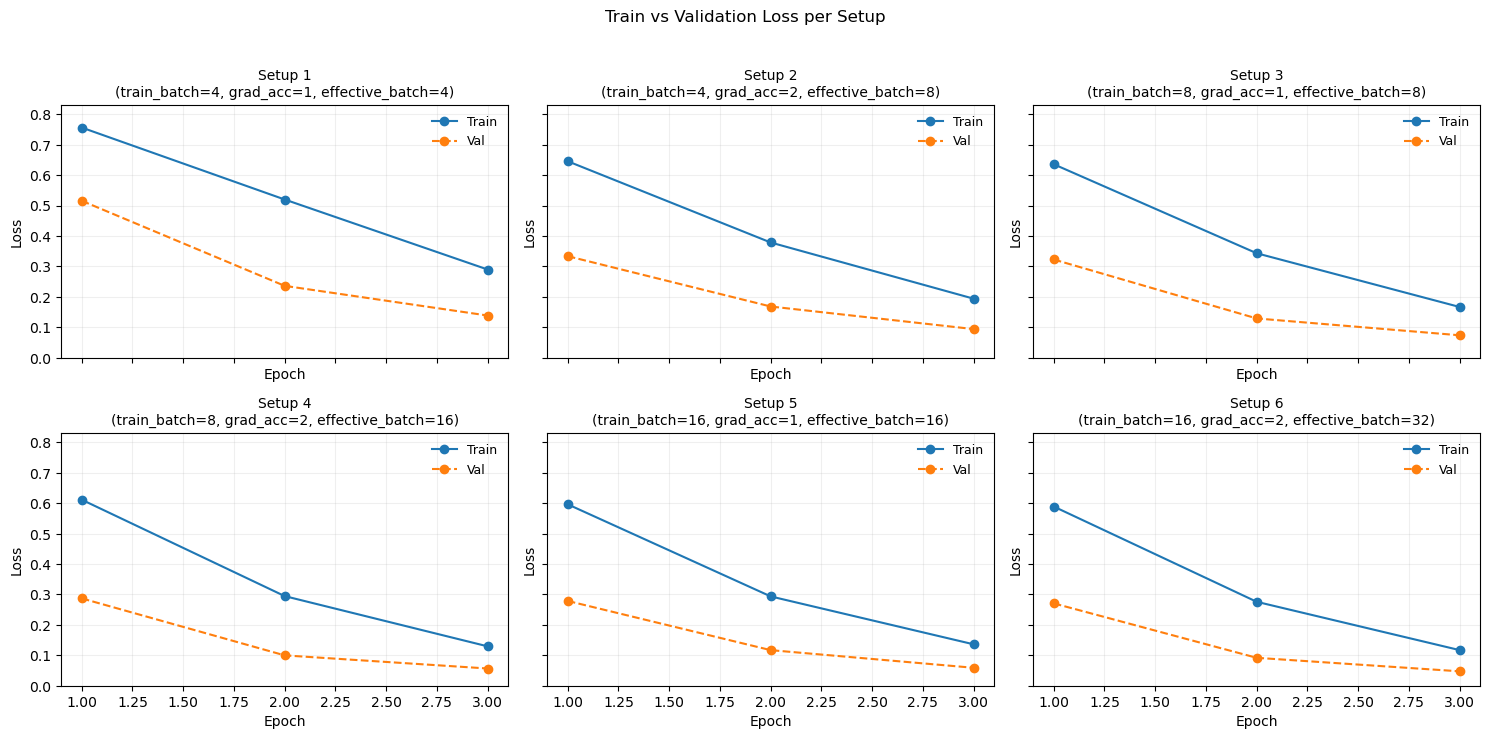

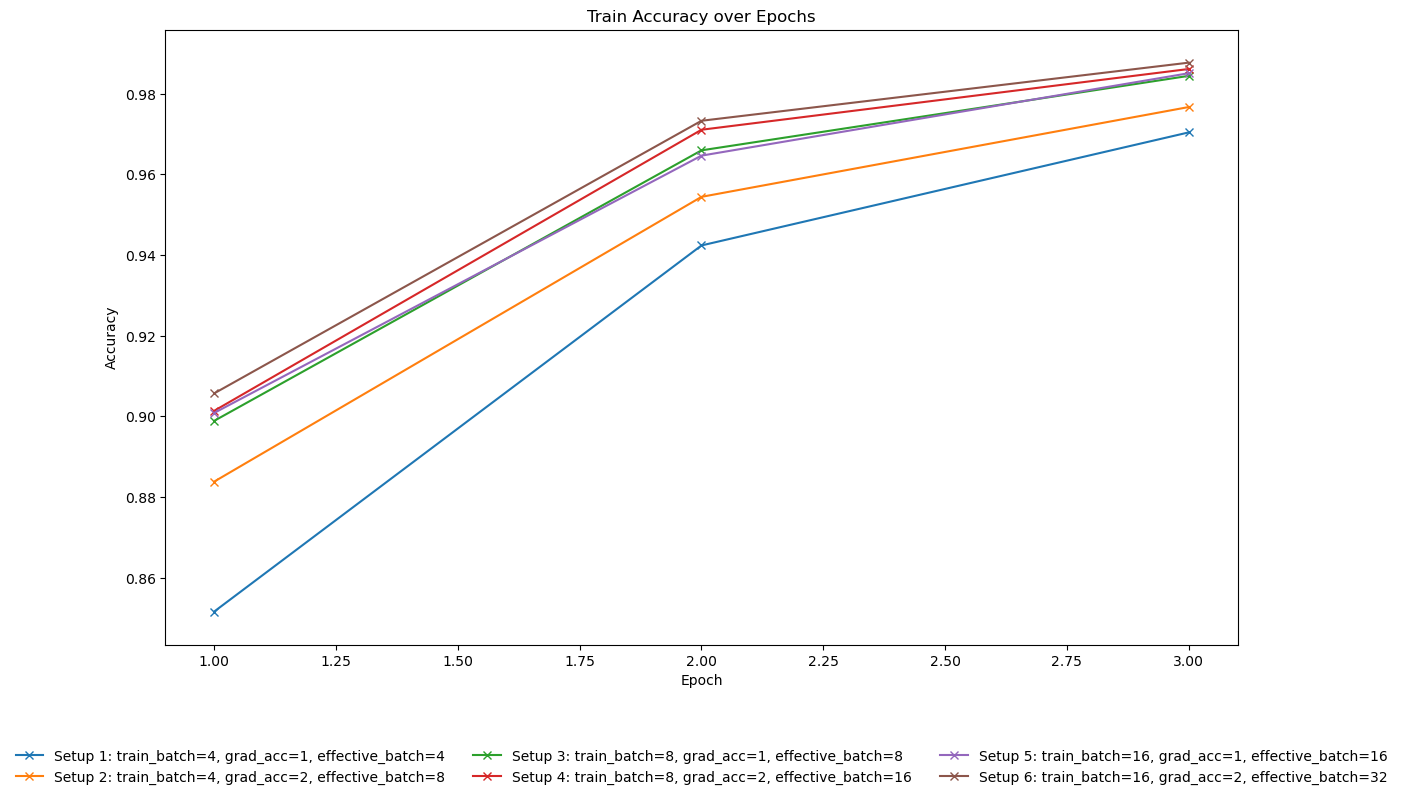

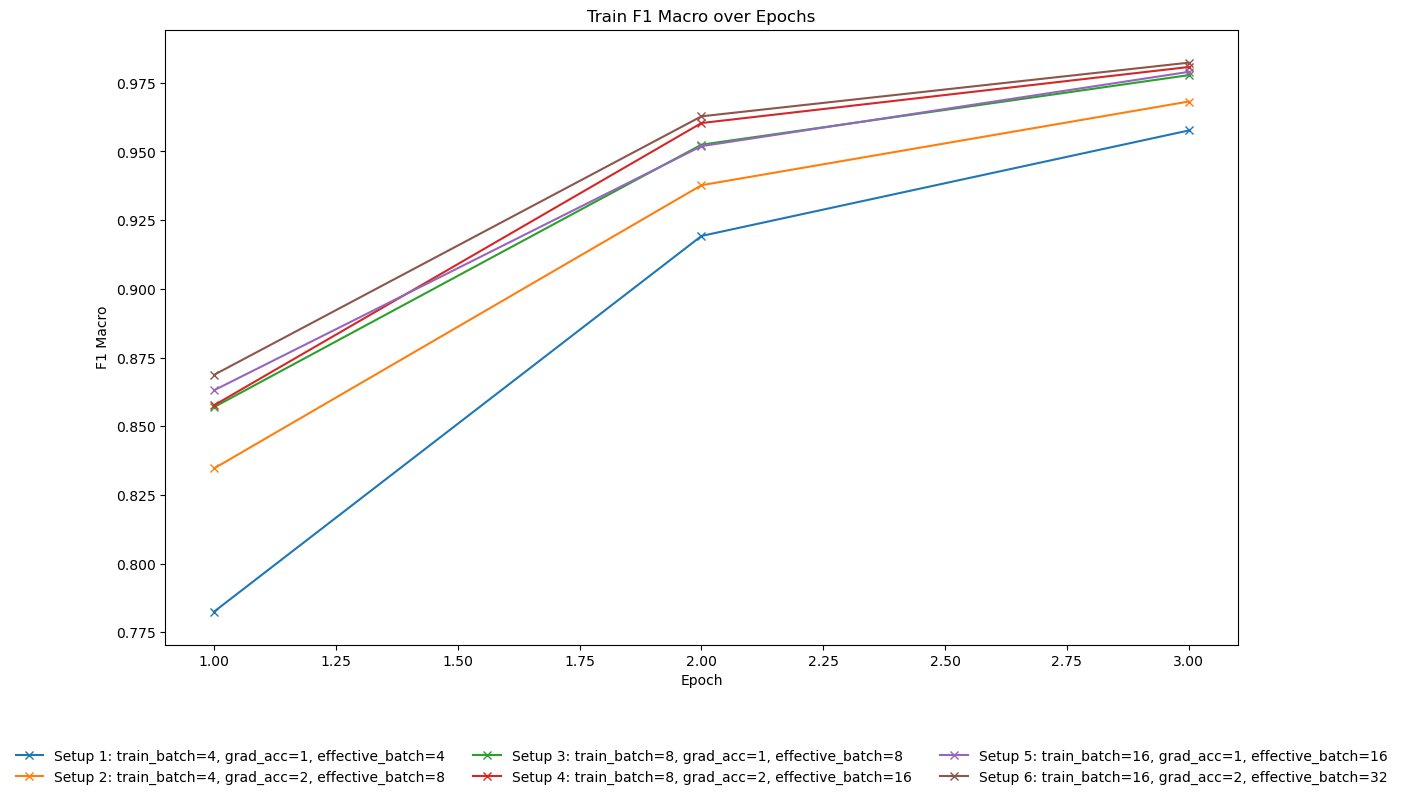

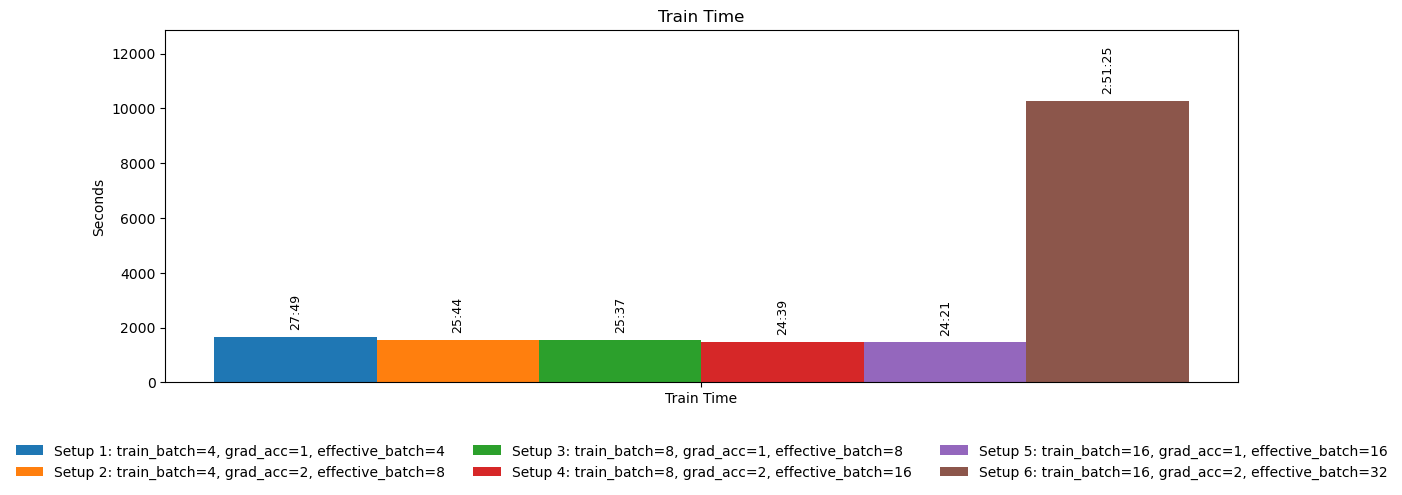

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt

run_ids = sorted(histories.keys())

# Train and validation Loss: one subplot per run (train vs val)
has_any_loss = any(("train_loss" in histories[r]) or ("val_loss" in histories[r]) for r in run_ids)
if has_any_loss:
    cols = 3
    rows = math.ceil(len(run_ids) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3.6*rows), sharex=True, sharey=True)
    axes = axes.ravel() if len(run_ids) > 1 else [axes]

    # global ymax for shared y-scale
    ymax = 0.0
    for r in run_ids:
        h = histories[r]
        if "train_loss" in h and len(h["train_loss"]) > 0:
            ymax = max(ymax, max(h["train_loss"]))
        if "val_loss" in h and len(h["val_loss"]) > 0:
            ymax = max(ymax, max(h["val_loss"]))

    last_ax_idx = -1
    for i, r in enumerate(run_ids):
        h = histories[r]; ax = axes[i]; last_ax_idx = i
        x = h["epochs"]

        if "train_loss" in h and len(h["train_loss"]) > 0:
            ax.plot(x, h["train_loss"], marker="o", label="Train")
        if "val_loss" in h and len(h["val_loss"]) > 0:
            ax.plot(x, h["val_loss"], marker="o", linestyle="--", label="Val")

        # Title with config details
        title = f"Setup {r}"
        if "config" in h:
            c = h["config"]
            title += f"\n(train_batch={c.get('train_batch')}, grad_acc={c.get('grad_acc')}, effective_batch={c.get('effective_batch')})"
        ax.set_title(title, fontsize=10)

        ax.set_ylim(0, ymax*1.10 if ymax > 0 else 1)
        ax.grid(alpha=0.2)
        ax.legend(frameon=False, fontsize=9)

    for ax in axes[:last_ax_idx+1]:
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")

    plt.suptitle("Train vs Validation Loss per Setup", y=1.02, fontsize=12)
    plt.tight_layout()
    plt.show()

# Accuracy and macro F1 - one figure per metric with lines = runs
metric_keys = [k for k in ["accuracy", "f1_macro"] if any(k in histories[r] for r in histories)]
run_ids = sorted(histories.keys())

for metric in metric_keys:
    plt.figure(figsize=(14, 8))

    # collect all values across runs to set a tight y-limit
    all_vals = []
    for r in run_ids:
        if metric in histories[r] and len(histories[r][metric]) > 0:
            all_vals.extend(histories[r][metric])

    y_min = min(all_vals)
    y_max = max(all_vals)
    span = max(1e-9, y_max - y_min)
    margin = 0.06 * span         # small padding
    min_span = 0.03              # ensure some vertical separation if near-flat
    if span < min_span:
        pad = 0.5 * (min_span - span)
        y_low, y_high = y_min - pad, y_max + pad
    else:
        y_low, y_high = y_min - margin, y_max + margin

    # clamp common bounded metrics to [0,1]
    if metric in {"accuracy", "f1_macro"}:
        y_low = max(0.0, y_low)
        y_high = min(1.0, y_high)

    # plot each run (plain lines) with legend labels that include config
    labels = []
    for r in run_ids:
        if metric not in histories[r] or len(histories[r][metric]) == 0:
            continue
        x = histories[r]["epochs"]
        y = histories[r][metric]
        cfg = histories[r].get("config", {})
        label = f"Setup {r}: train_batch={cfg.get('train_batch')}, grad_acc={cfg.get('grad_acc')}, effective_batch={cfg.get('effective_batch')}"
        labels.append(label)
        plt.plot(x, y, label=label, marker="x")

    plt.xlabel("Epoch")
    plt.ylabel(metric.replace("_", " ").title())
    plt.title(f"Train {metric.replace('_', ' ').title()} over Epochs")
    plt.ylim(y_low, y_high)

    # legend below the plot
    plt.legend(loc="upper center",
               bbox_to_anchor=(0.5, -0.15),
               ncol=min(len(labels), 3),
               frameon=False)
    plt.subplots_adjust(bottom=0.2)
    plt.tight_layout()
    plt.show()

# Time plot
run_ids = sorted(train_times.keys())

# legend labels from results
labels = []
for r in run_ids:
    cfg = results.get(r, {})
    if all(k in cfg for k in ("training batch size","gradient accumulation steps","effective training batch size")):
        labels.append(
            f"Setup {r}: train_batch={cfg['training batch size']}, "
            f"grad_acc={cfg['gradient accumulation steps']}, "
            f"effective_batch={cfg['effective training batch size']}"
        )
    else:
        labels.append(f"Setup {r}")

x = np.array([0])
n = len(run_ids)
total_w = 0.85
bar_w   = total_w / max(n, 1)
offsets = np.linspace(-total_w/2 + bar_w/2, total_w/2 - bar_w/2, n)

fig, ax = plt.subplots(figsize=(14, 5))  # wider figure

vals = np.array([float(train_times[r]) for r in run_ids], dtype=float)
ymax = float(vals.max())
y_top = ymax * 1.25 # prevent data labels from extending beyond plot border
ax.set_ylim(0, y_top)

# bar chart and data labels
for j, (r, lab) in enumerate(zip(run_ids, labels)):
    val = float(train_times[r])
    bar = ax.bar(x + offsets[j], [val], width=bar_w, label=lab)[0]

    # label as h:mm:ss, placed safely inside the plot area
    s = int(round(val)); h, rem = divmod(s, 3600); m, s = divmod(rem, 60)
    txt = f"{h:d}:{m:02d}:{s:02d}" if h else f"{m:02d}:{s:02d}"

    xpos = bar.get_x() + bar.get_width()/2.0
    ypos = min(val + y_top*0.02, y_top*0.98)  # keep inside top boundary
    ax.text(xpos, ypos, txt, ha="center", va="bottom", rotation=90, fontsize=9)

ax.set_xticks(x)
ax.set_xticklabels(["Train Time"])
ax.set_ylabel("Seconds")
ax.set_title("Train Time")

# legend below
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.14),
          ncol=min(n, 3), frameon=False)
plt.subplots_adjust(bottom=0.25)
plt.tight_layout()
plt.show()


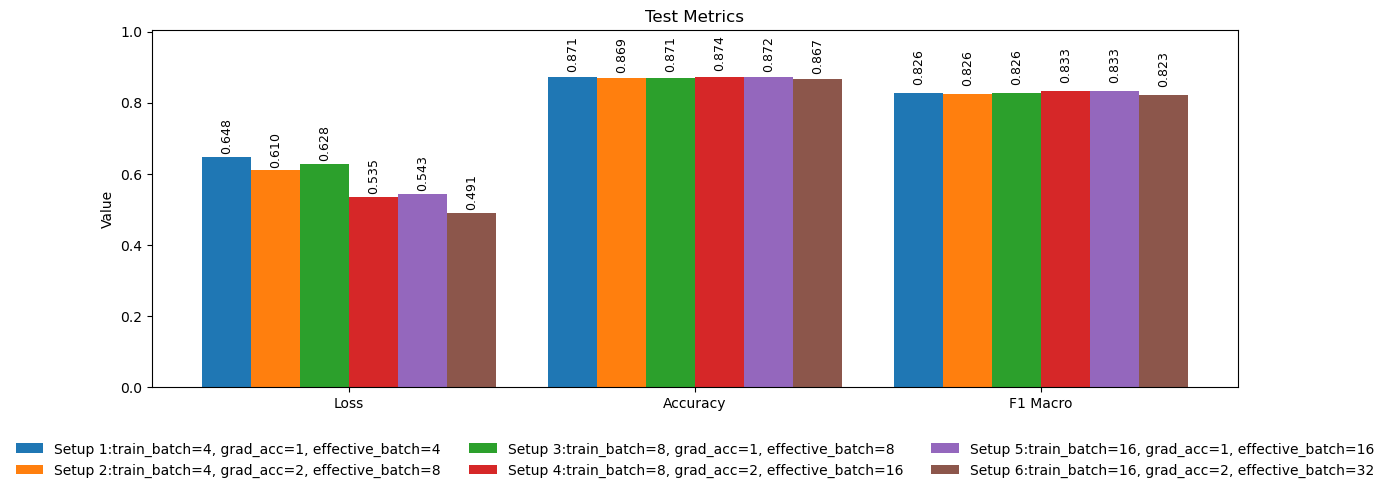

Displayed metrics chart.


In [ ]:
# Test Metrics plot (Loss / Accuracy / F1 Macro)
vals = {m: np.array([results[r][m] for r in run_ids], dtype=float) for m in test_metrics}

# legend labels with configs
legend_labels = []
for r in run_ids:
    tb  = results[r]["training batch size"]
    ga  = results[r]["gradient accumulation steps"]
    eff = results[r]["effective training batch size"]
    legend_labels.append(f"Setup {r}:train_batch={tb}, grad_acc={ga}, effective_batch={eff}")

x = np.arange(len(test_metrics))
n = len(run_ids)
total_w = 0.85
bar_w   = total_w / n
offsets = np.linspace(-total_w/2 + bar_w/2, total_w/2 - bar_w/2, n)

fig, ax = plt.subplots(figsize=(14, 5))
ymax = 0.0

for j, r in enumerate(run_ids):
    series = np.array([vals[m][j] for m in metrics], dtype=float)
    bars = ax.bar(x + offsets[j], series, width=bar_w, label=legend_labels[j])
    # data labels
    for k, (b, v) in enumerate(zip(bars, series)):
        pad = 2 + (k % 3) * 2
        ax.annotate(f"{v:.3f}", xy=(b.get_x()+b.get_width()/2.0, b.get_height()),
                    xytext=(0, pad), textcoords="offset points",
                    ha="center", va="bottom", rotation=90, fontsize=9)
    ymax = max(ymax, series.max())

ax.set_xticks(x)
ax.set_xticklabels([m.replace("_"," ").title() for m in metrics])
ax.set_ylabel("Value")
ax.set_title("Test Metrics")
ax.set_ylim(0, ymax * 1.15)

# legend at the bottom
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12),
          ncol=min(n, 3), frameon=False)
plt.subplots_adjust(bottom=0.22)
plt.tight_layout()
plt.show()
print("Displayed metrics chart.")